In [2]:
'''NOTE: DEPENDENCY AND IMPORTING CHECKS HAPPEN HERE'''
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import keras as kr
import os
import sys
import re
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from keras._tf_keras.keras.applications import ResNet50V2,VGG16
from tensorflow.python.keras.engine import data_adapter

# Print versions of dependencies
print("Status Active: Displaying Version Control")
print("---------------------")
print(f"TensorFlow: {tf.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Matplotlib: {mpl.__version__}")
print(f"OpenCV: {cv.__version__}")
print(f"Keras: {kr.__version__}")
print(f"Scikit-learn: {sys.modules['sklearn'].__version__}")


def _is_distributed_dataset(ds):

    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset


Status Active: Displaying Version Control
---------------------
TensorFlow: 2.18.0
NumPy: 2.0.2
Pandas: 2.2.3
Matplotlib: 3.10.0
OpenCV: 4.11.0
Keras: 3.8.0
Scikit-learn: 1.6.1


In [3]:
'''WHERE THE DATA PATHING AND SETTING IS FOUND'''

data_path_files = glob('datasets/dataset/*/*.png')
sorted_path = sorted(data_path_files,key=lambda x: int(re.search(r'(\d+)(?=\.png)', x).group(1)))
dataset_path = 'datasets/dataset/'
sam_num_0 = 0

sam_fpath_0 = sorted_path[sam_num_0]


In [4]:
def load_image(image_id:str):
    image_id = image_id.split('.')[0] if image_id.endswith('.png') else image_id.split('.')[0] if image_id.endswith('.png') else image_id
    file_path = image_id + ".png"
    image = cv.imread(file_path)
    image = cv.resize(image, (300,300))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def load_data() -> dict:
    # load data
    data_dir = dataset_path
    os.chdir(data_dir)
    dir_list = os.listdir()
    dir_list.sort()
    data = dict()
    for dir_name in tqdm(dir_list, desc='Loading data'):
        os.chdir(dir_name)
        image_list = [load_image(x) for x in os.listdir() if x.lower().endswith('.png')]
        print(dir_name, len(image_list))
        data[dir_name] = image_list
        os.chdir('..')
    os.chdir('../../../')
    return data



In [5]:
#plot image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
# load all data
data = load_data()

Loading data:  25%|██▌       | 1/4 [00:01<00:05,  1.71s/it]

-K 72


Loading data:  50%|█████     | 2/4 [00:03<00:03,  1.51s/it]

-N 58


Loading data:  75%|███████▌  | 3/4 [00:04<00:01,  1.54s/it]

-P 66


Loading data: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]

FN 12


In [7]:
NUM_CLASSES = len(data.keys())
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


In [8]:
# normalize data
def normalize_data(data: dict) -> dict:
    return {k: [x/255.0 for x in v] for k, v in data.items()}

nor_data = normalize_data(data)
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Number of classes: 4, Number of images: 208


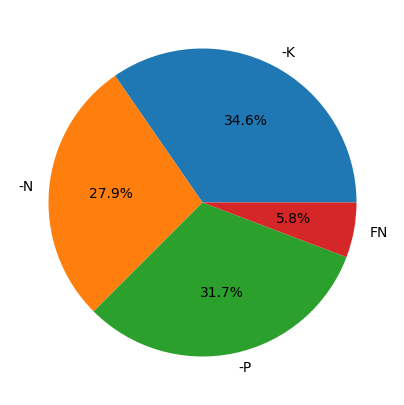

In [9]:
# plot pie chart of data(labels)
def plot_pie_chart(data: dict):
    plt.figure(figsize=(5, 5))
    plt.pie([len(x) for x in data.values()], labels=[x for x in data.keys()], autopct='%1.1f%%')
    plt.show()

def plot_bar_chart_df(data: pd.DataFrame):
    data.plot(kind='pie', subplots=True, figsize=(5, 5))
    plt.show()

plot_pie_chart(nor_data)

In [10]:
df = pd.DataFrame({'image': [x for x in nor_data.values() for x in x], 'label': [x for x in nor_data.keys() for _ in range(len(nor_data[x]))]})
df.head()

,image,label
0,"[[[0.5725490196078431, 0.5254901960784314, 0.4...",-K
1,"[[[0.9176470588235294, 0.9137254901960784, 0.9...",-K
2,"[[[0.9882352941176471, 1.0, 1.0], [0.996078431...",-K
3,"[[[0.8549019607843137, 0.8470588235294118, 0.8...",-K
4,"[[[0.9764705882352941, 0.9725490196078431, 0.9...",-K


In [11]:
# # Data Augmentation for label "FN"
def data_augmentation1(image):
    image = tf.image.flip_left_right(image)
    return image

def data_augmentation2(image):
    image = tf.image.flip_up_down(image)
    return image

def data_augmentation3(image):
    image = tf.image.rot90(image)
    return image

df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation1)
df_aug['label'] = 'FN'
df = pd.concat([df, df_aug], ignore_index=True)
df_aug = df[df['label'] == 'FN']
df_aug['image'] = df_aug['image'].apply(data_augmentation2)
df_aug['label'] = 'FN'
df:pd.DataFrame = pd.concat([df, df_aug], ignore_index=True)
df_aug = df
df_aug['image'] = df_aug['image'].apply(data_augmentation3)
df:pd.DataFrame = pd.concat([df, df_aug], ignore_index=True)

C:\Users\Poidachi\AppData\Local\Temp\ipykernel_13172\1704196927.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['image'] = df_aug['image'].apply(data_augmentation1)
C:\Users\Poidachi\AppData\Local\Temp\ipykernel_13172\1704196927.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aug['label'] = 'FN'
C:\Users\Poidachi\AppData\Local\Temp\ipykernel_13172\1704196927.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [12]:
print(f"Number of classes: {len(df['label'].unique())}, Number of images: {len(df)}")

Number of classes: 4, Number of images: 488


array([<Axes: ylabel='proportion'>], dtype=object)

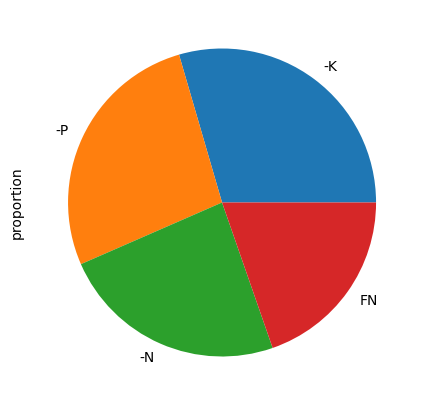

In [13]:
df.value_counts('label', normalize=True).plot(kind='pie', subplots=True, figsize=(5, 5))

In [14]:
# Label Encoding
def label_encoding(label):
    encoder = LabelEncoder()
    label = encoder.fit_transform(label)
    return label, encoder

df['label'], encoder = label_encoding(df['label'])
df.head()

,image,label
0,"(((tf.Tensor(0.5803921568627451, shape=(), dty...",0
1,"(((tf.Tensor(0.9725490196078431, shape=(), dty...",0
2,"(((tf.Tensor(0.8588235294117647, shape=(), dty...",0
3,"(((tf.Tensor(0.9450980392156862, shape=(), dty...",0
4,"(((tf.Tensor(0.9725490196078431, shape=(), dty...",0


In [15]:
for i, x in enumerate(encoder.classes_):
    print(f"Class {i}: {x}")

Class 0: -K
Class 1: -N
Class 2: -P
Class 3: FN


In [16]:
# Turn data into tensor and split data
def split_data(data: dict, test_size: float=0.2) -> tuple:
    X = np.array([x for x in data['image']])
    y = np.array([x for x in data['label']])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df.to_dict('list'))
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (390, 300, 300, 3), y_train: (390,), X_test: (98, 300, 300, 3), y_test: (98,)


In [17]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (390, 300, 300, 3), y_train shape: (390,)
X_test shape: (98, 300, 300, 3), y_test shape: (98,)


In [18]:
INPUT_SHAPE = X_train[0].shape

In [19]:
# Create model
model = kr.Sequential([
    kr.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=INPUT_SHAPE),
    kr.layers.MaxPooling2D(pool_size=(2, 2)),
    kr.layers.Flatten(),
    kr.layers.Dense(128, activation='relu'),
    kr.layers.Dense(NUM_CLASSES, activation='softmax')
])
opt = kr.optimizers.Adam(learning_rate=0.001)
loss =kr.losses.SparseCategoricalCrossentropy()
acc = kr.metrics.SparseCategoricalAccuracy()
model.compile(optimizer=opt, loss=loss, metrics=[acc])
model.summary()

c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2841728)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   363,741,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,745,412 (1.36 GB)

 Trainable params: 363,745,412 (1.36 GB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train model
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test, y_test))

Epoch 1/10
 2/13 ━━━━━━━━━━━━━━━━━━━━ 2:05 11s/step - loss: 69.8364 - sparse_categorical_accuracy: 0.3203

ResourceExhaustedError: Graph execution error:

Detected at node adam/Sub_10 defined at (most recent call last):
  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Poidachi\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3077, in run_cell

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3132, in _run_cell

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3336, in run_cell_async

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3519, in run_ast_nodes

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3579, in run_code

  File "C:\Users\Poidachi\AppData\Local\Temp\ipykernel_13172\3494397621.py", line 4, in <module>

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 80, in train_step

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py", line 383, in apply_gradients

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py", line 448, in apply

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\base_optimizer.py", line 511, in _backend_apply_gradients

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\optimizer.py", line 120, in _backend_update_step

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\optimizer.py", line 134, in _distributed_tf_update_step

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\optimizer.py", line 131, in apply_grad_to_update_var

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\optimizers\adam.py", line 133, in update_step

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\ops\numpy.py", line 5982, in subtract

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\sparse.py", line 493, in sparse_wrapper

  File "c:\Users\Poidachi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\numpy.py", line 370, in subtract

OOM when allocating tensor with shape[2841728,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node adam/Sub_10}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_multi_step_on_iterator_1610199]

In [ ]:
# Plot loss and accuracy

def plot_loss_and_accuracy(history: kr.callbacks.History):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
plot_loss_and_accuracy(history)
plot_confusion_matrix(model, X_test, y_test)